# Prédiction de l'Evenements Clients

## 1. Introduction

La visions à accomplir ce qui suit pour cette étude :

1. Identifier et visualiser les facteurs qui contribuent à l'attrition des clients :

2. Construie un modèle de prédiction qui effectuera les opérations suivantes :

    - Classifier si un client va se désabonner ou non.
    - De préférence et en fonction des performances du modèle, choisissez un modèle qui associera une probabilité au taux de désabonnement pour permettre au service client de cibler plus facilement les fruits à portée de main dans leurs efforts pour empêcher le désabonnement

## 2. Test et préparation de la DataSet

Dans cette section, nous chercherons à explorer la structure de nos données : 
1. Pour comprendre l'espace d'entrée de Data set. 
2. Et pour préparer les ensembles pour les tâches exploratoires et prédictives comme décrit dans la section 1

In [1]:
## BIBLIOTHÈQUES REQUISES
# pour data wrangling 
import numpy as np
import pandas as pd

# pour visualisation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.options.display.max_rows = None
pd.options.display.max_columns = None
import warnings

In [2]:
# Lire la data frame
df = pd.read_csv("Upload_Data/Bank_Data.csv", delimiter=',')
df.shape

(10000, 14)

Le Df a 1000 lignes avec 14 attributs. j'examine cela plus en détail pour identifier quels attributs seront nécessaires et quelle manipulation de données doit être effectuée avant l'analyse exploratoire et la modélisation de prédiction

In [3]:
# Vérifier la liste des colonnes et les valeurs manquantes
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

pas de valeurs manquantes !

In [4]:
# Obtenir un nombre unique pour chaque variable
df.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

D'après ce qui précède, nous n'exigerons pas les 2 premiers attributs car ils sont spécifiques à un client. Il est à la limite du nom de famille car cela entraînerait un profilage, je l'exclue donc également.

In [5]:
# Drop les colonnes comme expliqué ci-dessus
df = df.drop(["RowNumber", "CustomerId", "Surname"], axis = 1)

In [6]:
# Revoir les premières lignes de ce qui reste du bloc de données
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


De ce qui précède, quelques questions subsistent :

1. Les données semblent être un instantané à un moment donné, par ex. le solde est pour une date donnée ce qui laisse beaucoup de questions :
    - De quelle date s'agit-il et de quelle importance cette date est-elle ?
    - Serait-il possible d'obtenir des soldes sur une période de temps plutôt que sur une seule date ?
2. Il y a des clients qui sont sortis mais qui ont encore un solde sur leur compte ! Qu'est-ce que cela signifierait? Auraient-ils pu sortir d'un produit et non de la banque ?
3. Que signifie être un membre actif et y a-t-il des degrés différents? Serait-il préférable de fournir le nombre de transactions à la fois en termes de crédits et de débits sur le compte ?
4. Une ventilation des produits achetés par un client pourrait fournir plus d'informations en tête de liste du nombre de produits.

Pour cet exercice, je procéde à la modélisation sans contexte même si généralement avoir un contexte et une meilleure compréhension du processus d'extraction de données donnerait une meilleure idée et conduirait peut-être à des résultats meilleurs et contextuels du processus de modélisation.

In [7]:
# Vérifier les types de données variables
df.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

On a donc majoritairement des variables catégorielles et 5 variables continues

## 3. Explorer Data Analysis

Ici, notre principal intérêt est de comprendre comment les attributs donnés se rapportent au statut 'Exit'.

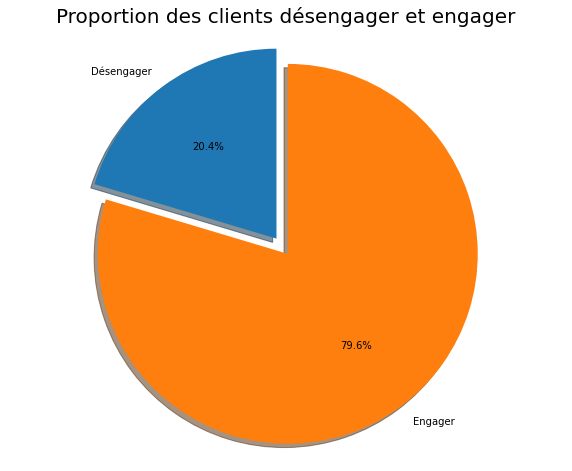

In [8]:
labels = 'Désengager', 'Engager'
sizes = [df.Exited[df['Exited']==1].count(), df.Exited[df['Exited']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion des clients désengager et engager", size = 20)
plt.show()

Environ 20% des clients ont désengagés. Ainsi, le modèle de référence pourrait être de prédire que 20 % des clients seront désengagés. Étant donné que 20 % est un petit nombre, nous devons nous assurer que le modèle choisi prédit avec une grande précision ces 20 %, car il est dans l'intérêt de la banque d'identifier et de conserver ce groupe plutôt que de prédire avec précision les clients engager.

<AxesSubplot:xlabel='IsActiveMember', ylabel='count'>

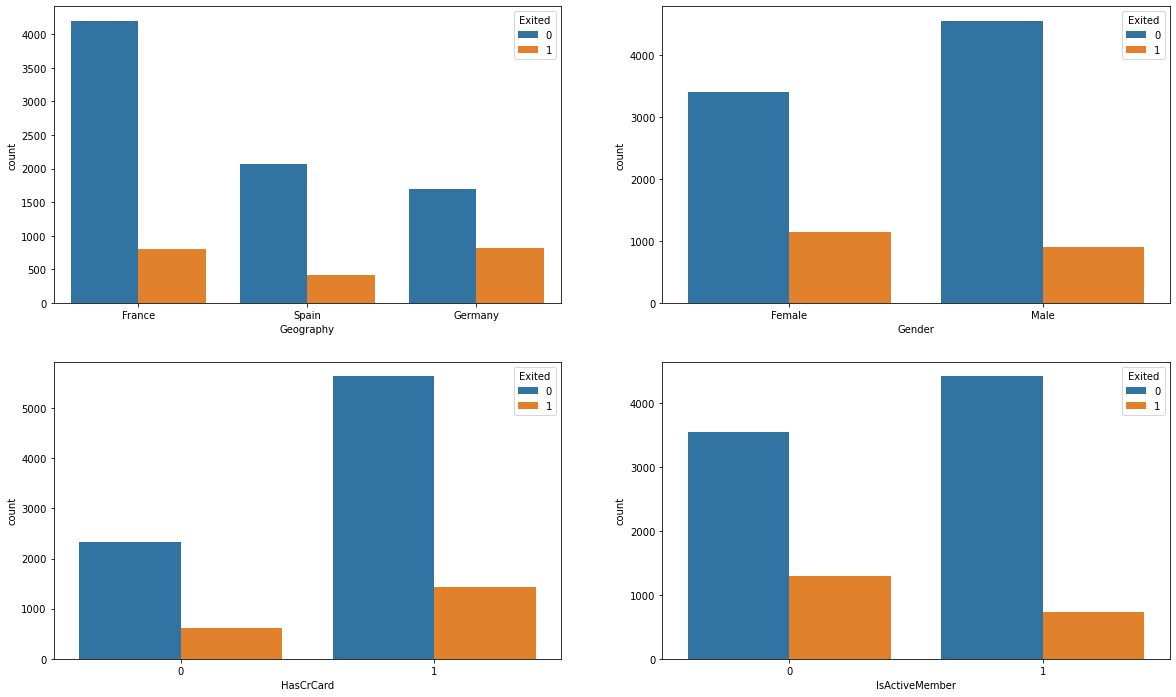

In [9]:
# Examiner d'abord la relation « Status » avec les variables catégorielles
fig, axarr = plt.subplots(2, 2, figsize=(20, 12))
sns.countplot(x='Geography', hue = 'Exited',data = df, ax=axarr[0][0])
sns.countplot(x='Gender', hue = 'Exited',data = df, ax=axarr[0][1])
sns.countplot(x='HasCrCard', hue = 'Exited',data = df, ax=axarr[1][0])
sns.countplot(x='IsActiveMember', hue = 'Exited',data = df, ax=axarr[1][1])

Noter ce qui suit :

- La majorité des données proviennent de personnes de France. Cependant, la proportion de clients désengager est inversement liée à la population de clients faisant allusion au fait que la banque a éventuellement un problème (peut-être pas assez de ressources de service client allouées) dans les zones où elle a moins de clients.
- La proportion de clients féminins désengagées est également supérieure à celle des clients masculins.
- La majorité des clients qui sont désengagés  sont ceux avec des cartes de crédit. Étant donné que la majorité des clients ont des cartes de crédit, il pourrait s'agir d'une simple coïncidence.
- Les membres inactifs ont un taux de désengagement plus important. Il est inquiétant de constater que la proportion globale de membres inactifs est assez élevée, ce qui suggère que la banque pourrait avoir besoin d'un programme mis en œuvre pour transformer ce groupe en clients actifs, car cela aura certainement un impact positif sur le taux de désengagement des clients.

<AxesSubplot:xlabel='Exited', ylabel='EstimatedSalary'>

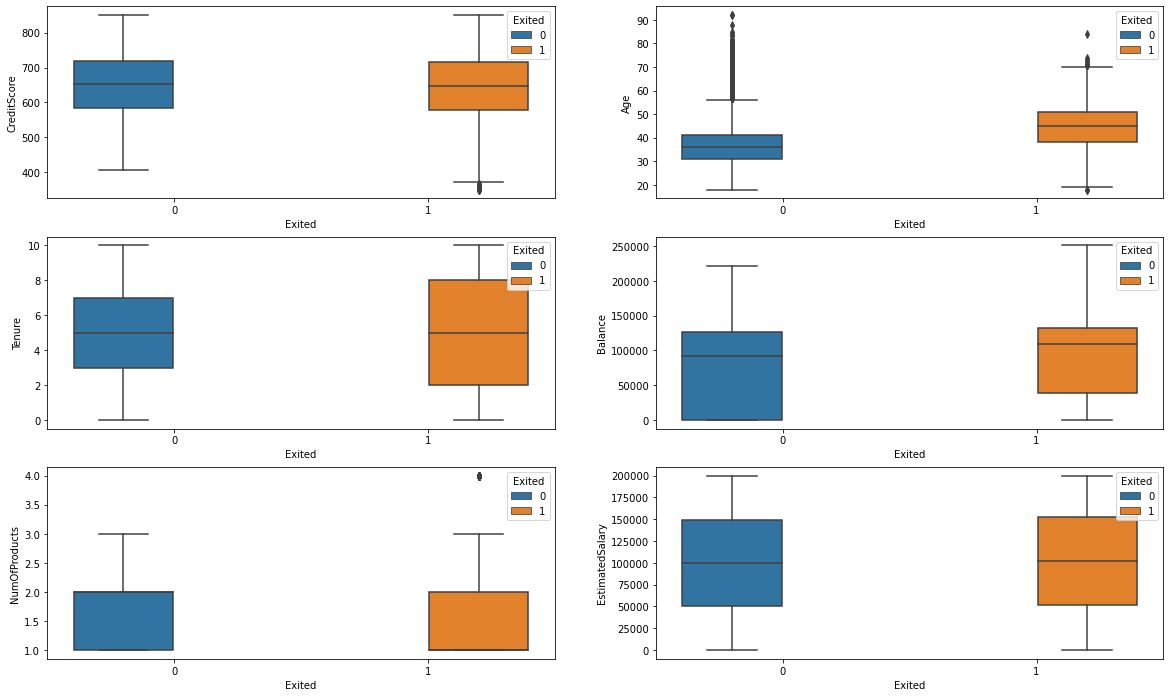

In [10]:
# Relations basées sur les attributs de données continues
fig, axarr = plt.subplots(3, 2, figsize=(20, 12))
sns.boxplot(y='CreditScore',x = 'Exited', hue = 'Exited',data = df, ax=axarr[0][0])
sns.boxplot(y='Age',x = 'Exited', hue = 'Exited',data = df , ax=axarr[0][1])
sns.boxplot(y='Tenure',x = 'Exited', hue = 'Exited',data = df, ax=axarr[1][0])
sns.boxplot(y='Balance',x = 'Exited', hue = 'Exited',data = df, ax=axarr[1][1])
sns.boxplot(y='NumOfProducts',x = 'Exited', hue = 'Exited',data = df, ax=axarr[2][0])
sns.boxplot(y='EstimatedSalary',x = 'Exited', hue = 'Exited',data = df, ax=axarr[2][1])

Noter ce qui suit :

- Il n'y a pas de différence significative dans la répartition du pointage de crédit entre les clients engager et les clients désengagés.
- Les clients plus âgés sont plus nombreux que les plus jeunes, faisant allusion à une différence de préférence de service dans les catégories d'âge. La banque peut avoir besoin de revoir son marché cible ou de revoir la stratégie de rétention entre les différents groupes d'âge
- En ce qui concerne l'ancienneté, les clients aux extrémités (passé peu de temps avec la banque ou beaucoup de temps avec la banque) sont plus susceptibles de se désengager que ceux qui ont une ancienneté moyenne.
- De manière inquiétante, la banque perd des clients avec des soldes bancaires importants, ce qui risque d'affecter leur capital disponible pour les prêts.
- Ni le produit ni le salaire n'ont d'effet significatif sur la probabilité de désgagement.

chercher à ajouter des fonctionnalités susceptibles d'avoir un impact sur la probabilité de barattage. Avoir d'abord divisé le train et les ensembles de test

In [11]:
# Split Train, test data
df_train = df.sample(frac=0.8,random_state=200)
df_test = df.drop(df_train.index)
print(len(df_train))
print(len(df_test))

8000
2000


(-1.0, 5.0)

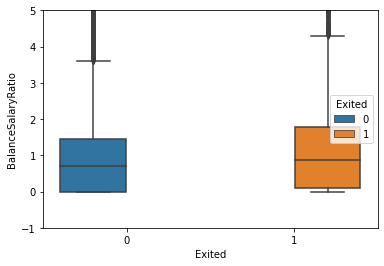

In [12]:
df_train['BalanceSalaryRatio'] = df_train.Balance/df_train.EstimatedSalary
sns.boxplot(y='BalanceSalaryRatio',x = 'Exited', hue = 'Exited',data = df_train)
plt.ylim(-1, 5)

Avoir vu que le salaire a peu d'effet sur les chances de désengagement d'un client. Cependant, comme vu ci-dessus, le ratio du solde bancaire et du salaire estimé indique que les clients avec un ratio de salaire de solde plus élevé chutent davantage, ce qui serait inquiétant pour la banque car cela impacte leur source de capital d'emprunt.

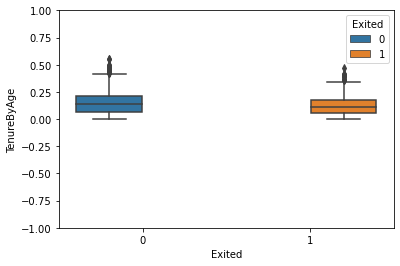

In [13]:
# Étant donné que l'ancienneté est une « fonction » de l'âge, nous introduisons une variable visant à standardiser l'ancienneté en fonction de l'âge:
df_train['TenureByAge'] = df_train.Tenure/(df_train.Age)
sns.boxplot(y='TenureByAge',x = 'Exited', hue = 'Exited',data = df_train)
plt.ylim(-1, 1)
plt.show()

In [14]:
'''Introduire une variable pour capturer le score de crédit en fonction de l'âge pour prendre en compte le comportement de crédit vis-à-vis de la vie adulte :-)'''
df_train['CreditScoreGivenAge'] = df_train.CreditScore/(df_train.Age)

In [15]:
# Résultat Data Frame
df_train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge
8159,461,Spain,Female,25,6,0.00,2,1,1,15306.29,0,0.000000,0.240000,18.440000
6332,619,France,Female,35,4,90413.12,1,1,1,20555.21,0,4.398550,0.114286,17.685714
8895,699,France,Female,40,8,122038.34,1,1,0,102085.35,0,1.195454,0.200000,17.475000
5351,558,Germany,Male,41,2,124227.14,1,1,1,111184.67,0,1.117305,0.048780,13.609756
4314,638,France,Male,34,5,133501.36,1,0,1,155643.04,0,0.857741,0.147059,18.764706


## 5. Préparation des données pour l'ajustement du modèle

In [16]:
# Organiser les colonnes par type de données pour une manipulation plus facile
continuous_vars = ['CreditScore',  'Age', 'Tenure', 'Balance','NumOfProducts', 'EstimatedSalary', 'BalanceSalaryRatio',
                   'TenureByAge','CreditScoreGivenAge']
cat_vars = ['HasCrCard', 'IsActiveMember','Geography', 'Gender']
df_train = df_train[['Exited'] + continuous_vars + cat_vars]
df_train.head()

,Exited,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,HasCrCard,IsActiveMember,Geography,Gender
8159,0,461,25,6,0.00,2,15306.29,0.000000,0.240000,18.440000,1,1,Spain,Female
6332,0,619,35,4,90413.12,1,20555.21,4.398550,0.114286,17.685714,1,1,France,Female
8895,0,699,40,8,122038.34,1,102085.35,1.195454,0.200000,17.475000,1,0,France,Female
5351,0,558,41,2,124227.14,1,111184.67,1.117305,0.048780,13.609756,1,1,Germany,Male
4314,0,638,34,5,133501.36,1,155643.04,0.857741,0.147059,18.764706,0,1,France,Male


In [17]:
'''Pour les variables, on modifiant 0 à -1 afin que les modèles puissent capturer une relation négative
où l'attribut est inapplicable au lieu de 0'''
df_train.loc[df_train.HasCrCard == 0, 'HasCrCard'] = -1
df_train.loc[df_train.IsActiveMember == 0, 'IsActiveMember'] = -1
df_train.head()

,Exited,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,HasCrCard,IsActiveMember,Geography,Gender
8159,0,461,25,6,0.00,2,15306.29,0.000000,0.240000,18.440000,1,1,Spain,Female
6332,0,619,35,4,90413.12,1,20555.21,4.398550,0.114286,17.685714,1,1,France,Female
8895,0,699,40,8,122038.34,1,102085.35,1.195454,0.200000,17.475000,1,-1,France,Female
5351,0,558,41,2,124227.14,1,111184.67,1.117305,0.048780,13.609756,1,1,Germany,Male
4314,0,638,34,5,133501.36,1,155643.04,0.857741,0.147059,18.764706,-1,1,France,Male


In [18]:
lst = ['Geography', 'Gender']
remove = list()
for i in lst:
    if (df_train[i].dtype == np.str or df_train[i].dtype == np.object):
        for j in df_train[i].unique():
            df_train[i+'_'+j] = np.where(df_train[i] == j,1,-1)
        remove.append(i)
df_train = df_train.drop(remove, axis=1)
df_train.head()

,Exited,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,HasCrCard,IsActiveMember,Geography_Spain,Geography_France,Geography_Germany,Gender_Female,Gender_Male
8159,0,461,25,6,0.00,2,15306.29,0.000000,0.240000,18.440000,1,1,1,-1,-1,1,-1
6332,0,619,35,4,90413.12,1,20555.21,4.398550,0.114286,17.685714,1,1,-1,1,-1,1,-1
8895,0,699,40,8,122038.34,1,102085.35,1.195454,0.200000,17.475000,1,-1,-1,1,-1,1,-1
5351,0,558,41,2,124227.14,1,111184.67,1.117305,0.048780,13.609756,1,1,-1,-1,1,-1,1
4314,0,638,34,5,133501.36,1,155643.04,0.857741,0.147059,18.764706,-1,1,-1,1,-1,-1,1


In [19]:
# minMax mise à l'échelle des variables continues
minVec = df_train[continuous_vars].min().copy()
maxVec = df_train[continuous_vars].max().copy()
df_train[continuous_vars] = (df_train[continuous_vars]-minVec)/(maxVec-minVec)
df_train.head()

,Exited,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,HasCrCard,IsActiveMember,Geography_Spain,Geography_France,Geography_Germany,Gender_Female,Gender_Male
8159,0,0.222,0.094595,0.6,0.000000,0.333333,0.076118,0.000000,0.432000,0.323157,1,1,1,-1,-1,1,-1
6332,0,0.538,0.229730,0.4,0.360358,0.000000,0.102376,0.003317,0.205714,0.305211,1,1,-1,1,-1,1,-1
8895,0,0.698,0.297297,0.8,0.486406,0.000000,0.510225,0.000901,0.360000,0.300198,1,-1,-1,1,-1,1,-1
5351,0,0.416,0.310811,0.2,0.495130,0.000000,0.555744,0.000843,0.087805,0.208238,1,1,-1,-1,1,-1,1
4314,0,0.576,0.216216,0.5,0.532094,0.000000,0.778145,0.000647,0.264706,0.330882,-1,1,-1,1,-1,-1,1


In [20]:
# data prep pipeline
def DfPrepPipeline(df_predict,df_train_Cols,minVec,maxVec):
    # Ajouter de nouvelles fonctionnalités
    df_predict['BalanceSalaryRatio'] = df_predict.Balance/df_predict.EstimatedSalary
    df_predict['TenureByAge'] = df_predict.Tenure/(df_predict.Age - 18)
    df_predict['CreditScoreGivenAge'] = df_predict.CreditScore/(df_predict.Age - 18)
    # Réorganiser les colonnes
    continuous_vars = ['CreditScore','Age','Tenure','Balance','NumOfProducts','EstimatedSalary','BalanceSalaryRatio',
                   'TenureByAge','CreditScoreGivenAge']
    cat_vars = ['HasCrCard','IsActiveMember',"Geography", "Gender"] 
    df_predict = df_predict[['Exited'] + continuous_vars + cat_vars]
    # Changer le 0 dans les variables catégorielles par -1
    df_predict.loc[df_predict.HasCrCard == 0, 'HasCrCard'] = -1
    df_predict.loc[df_predict.IsActiveMember == 0, 'IsActiveMember'] = -1
    # On encode les variables catégorielles
    lst = ["Geography", "Gender"]
    remove = list()
    for i in lst:
        for j in df_predict[i].unique():
            df_predict[i+'_'+j] = np.where(df_predict[i] == j,1,-1)
        remove.append(i)
    df_predict = df_predict.drop(remove, axis=1)
    # Assurer que toutes les variables codées qui apparaissent dans les données de train apparaissent dans les données suivantes
    L = list(set(df_train_Cols) - set(df_predict.columns))
    for l in L:
        df_predict[str(l)] = -1        
    # Variables continues de mise à l'échelle MinMax basées sur le min et le max des données du train
    df_predict[continuous_vars] = (df_predict[continuous_vars]-minVec)/(maxVec-minVec)
    # Assurer que les variables sont ordonnées de la même manière que dans le train set
    df_predict = df_predict[df_train_Cols]
    return df_predict

## 6. Ajustement et sélection du modèle

Pour l'essayage du modèle, je vais essayer ce qui suit

- Régression logistique dans l'espace primal et avec différents noyaux
- SVM dans le primal et avec différents noyaux
- Modèles d'ensemble

In [21]:
# fonctions de support
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform

# Ajuster les modèles
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


# Fonctions de scoring
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [22]:
# Fonction pour donner le meilleur score et les meilleurs paramètres du modèle
def best_model(model):
    print(model.best_score_)    
    print(model.best_params_)
    print(model.best_estimator_)
def get_auc_scores(y_actual, method,method2):
    auc_score = roc_auc_score(y_actual, method); 
    fpr_df, tpr_df, _ = roc_curve(y_actual, method2); 
    return (auc_score, fpr_df, tpr_df)

#### Cette section prend beaucoup de temps à s'exécuter,

In [51]:
# Fit primal logistic regression
param_grid = {'C': [0.1,0.5,1,10,50,100], 'max_iter': [250], 'fit_intercept':[True],'intercept_scaling':[1],
              'penalty':['l2'], 'tol':[0.00001,0.0001,0.000001]}
log_primal_Grid = GridSearchCV(LogisticRegression(solver='lbfgs'),param_grid, cv=10, refit=True, verbose=0)
log_primal_Grid.fit(df_train.loc[:, df_train.columns != 'Exited'],df_train.Exited)
best_model(log_primal_Grid)

0.8149999999999998
{'C': 100, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 250, 'penalty': 'l2', 'tol': 1e-05}
LogisticRegression(C=100, max_iter=250, tol=1e-05)


In [53]:
# Fit logistic regression with degree 2 polynomial kernel
param_grid = {'C': [0.1,10,50], 'max_iter': [300,500], 'fit_intercept':[True],'intercept_scaling':[1],'penalty':['l2'],
              'tol':[0.0001,0.000001]}
poly2 = PolynomialFeatures(degree=2)
df_train_pol2 = poly2.fit_transform(df_train.loc[:, df_train.columns != 'Exited'])
log_pol2_Grid = GridSearchCV(LogisticRegression(solver = 'liblinear'),param_grid, cv=5, refit=True, verbose=0)
log_pol2_Grid.fit(df_train_pol2,df_train.Exited)
best_model(log_pol2_Grid)

0.8553750000000001
{'C': 50, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 300, 'penalty': 'l2', 'tol': 0.0001}
LogisticRegression(C=50, max_iter=300, solver='liblinear')


In [54]:
# Fit SVM with RBF Kernel
param_grid = {'C': [0.5,100,150], 'gamma': [0.1,0.01,0.001],'probability':[True],'kernel': ['rbf']}
SVM_grid = GridSearchCV(SVC(), param_grid, cv=3, refit=True, verbose=0)
SVM_grid.fit(df_train.loc[:, df_train.columns != 'Exited'],df_train.Exited)
best_model(SVM_grid)

0.8518747609662071
{'C': 100, 'gamma': 0.1, 'kernel': 'rbf', 'probability': True}
SVC(C=100, gamma=0.1, probability=True)


In [55]:
# Fit SVM with pol kernel
param_grid = {'C': [0.5,1,10,50,100], 'gamma': [0.1,0.01,0.001],'probability':[True],'kernel': ['poly'],'degree':[2,3] }
SVM_grid = GridSearchCV(SVC(), param_grid, cv=3, refit=True, verbose=0)
SVM_grid.fit(df_train.loc[:, df_train.columns != 'Exited'],df_train.Exited)
best_model(SVM_grid)

0.8544999485716948
{'C': 100, 'degree': 2, 'gamma': 0.1, 'kernel': 'poly', 'probability': True}
SVC(C=100, degree=2, gamma=0.1, kernel='poly', probability=True)


In [58]:
# Fit random forest classifier
param_grid = {'max_depth': [3, 5, 6, 7, 8], 'max_features': [2,4,6,7,8,9],'n_estimators':[50,100],'min_samples_split': [3, 5, 6, 7]}
RanFor_grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, refit=True, verbose=0)
RanFor_grid.fit(df_train.loc[:, df_train.columns != 'Exited'],df_train.Exited)
best_model(RanFor_grid)

0.8640000000000001
{'max_depth': 8, 'max_features': 7, 'min_samples_split': 7, 'n_estimators': 100}
RandomForestClassifier(max_depth=8, max_features=7, min_samples_split=7)


In [88]:
# Fit Extreme Gradient boosting classifier
param_grid = {'max_depth': [5,6,7,8], 'gamma': [0.01,0.001,0.001],'min_child_weight':[1,5,10], 'learning_rate': [0.05,0.1, 0.2, 0.3], 'n_estimators':[5,10,20,100]}
xgb_grid = GridSearchCV(XGBClassifier(), param_grid, cv=5, refit=True, verbose=0)
xgb_grid.fit(df_train.loc[:, df_train.columns != 'Exited'],df_train.Exited)
best_model(xgb_grid)

C:\Users\Hp\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:35:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:35:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:35:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:35:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

KeyboardInterrupt: 

#### Ajuster les meilleurs modèles

In [23]:
# Fit primal logistic regression
log_primal = LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,intercept_scaling=1, max_iter=250, multi_class='ovr',
                                n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',tol=1e-05, verbose=0, warm_start=False)
log_primal.fit(df_train.loc[:, df_train.columns != 'Exited'],df_train.Exited)

LogisticRegression(C=100, max_iter=250, multi_class='ovr', tol=1e-05)

In [24]:
# Fit logistic regression with pol 2 kernel
poly2 = PolynomialFeatures(degree=2)
df_train_pol2 = poly2.fit_transform(df_train.loc[:, df_train.columns != 'Exited'])
log_pol2 = LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,intercept_scaling=1, max_iter=300, multi_class='ovr', n_jobs=None, 
                              penalty='l2', random_state=None, solver='liblinear',tol=0.0001, verbose=0, warm_start=False)
log_pol2.fit(df_train_pol2,df_train.Exited)

LogisticRegression(C=10, max_iter=300, multi_class='ovr', solver='liblinear')

In [25]:
# Fit SVM with RBF Kernel
SVM_RBF = SVC(C=100, cache_size=200, class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf', max_iter=-1, probability=True, 
              random_state=None, shrinking=True,tol=0.001, verbose=False)
SVM_RBF.fit(df_train.loc[:, df_train.columns != 'Exited'],df_train.Exited)

SVC(C=100, gamma=0.1, probability=True)

In [26]:
# Fit SVM with Pol Kernel
SVM_POL = SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,  decision_function_shape='ovr', degree=2, gamma=0.1, kernel='poly',  max_iter=-1,
              probability=True, random_state=None, shrinking=True, tol=0.001, verbose=False)
SVM_POL.fit(df_train.loc[:, df_train.columns != 'Exited'],df_train.Exited)

SVC(C=100, degree=2, gamma=0.1, kernel='poly', probability=True)

In [27]:
# Fit Random Forest classifier
RF = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',max_depth=8, max_features=6, max_leaf_nodes=None,min_impurity_decrease=0.0,
                            min_impurity_split=None,min_samples_leaf=1, min_samples_split=3,min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
                            oob_score=False, random_state=None, verbose=0,warm_start=False)
RF.fit(df_train.loc[:, df_train.columns != 'Exited'],df_train.Exited)

RandomForestClassifier(max_depth=8, max_features=6, min_samples_split=3,
                       n_estimators=50)

In [30]:
# Fit Extreme Gradient Boost Classifier
XGB = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,colsample_bytree=1, gamma=0.01, learning_rate=0.1, max_delta_step=0,max_depth=7,
                    min_child_weight=5, missing=1, n_estimators=20,n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,reg_alpha=0, 
                    reg_lambda=1, scale_pos_weight=1, seed=42,subsample=1, eval_metric='mlogloss')#,warm_start=False)
XGB.fit(df_train.loc[:, df_train.columns != 'Exited'],df_train.Exited)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0.01, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=7, min_child_weight=5, missing=1,
              monotone_constraints='()', n_estimators=20, n_jobs=1, nthread=1,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=42, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [31]:
print(classification_report(df_train.Exited, log_primal.predict(df_train.loc[:, df_train.columns != 'Exited'])))

              precision    recall  f1-score   support

           0       0.83      0.97      0.89      6353
           1       0.64      0.24      0.35      1647

    accuracy                           0.82      8000
   macro avg       0.73      0.60      0.62      8000
weighted avg       0.79      0.82      0.78      8000



In [32]:
print(classification_report(df_train.Exited,  log_pol2.predict(df_train_pol2)))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      6353
           1       0.77      0.46      0.57      1647

    accuracy                           0.86      8000
   macro avg       0.82      0.71      0.75      8000
weighted avg       0.85      0.86      0.85      8000



In [33]:
print(classification_report(df_train.Exited,  SVM_RBF.predict(df_train.loc[:, df_train.columns != 'Exited'])))

              precision    recall  f1-score   support

           0       0.86      0.98      0.92      6353
           1       0.85      0.40      0.54      1647

    accuracy                           0.86      8000
   macro avg       0.86      0.69      0.73      8000
weighted avg       0.86      0.86      0.84      8000



In [34]:
print(classification_report(df_train.Exited,  SVM_POL.predict(df_train.loc[:, df_train.columns != 'Exited'])))

              precision    recall  f1-score   support

           0       0.86      0.98      0.92      6353
           1       0.84      0.38      0.52      1647

    accuracy                           0.86      8000
   macro avg       0.85      0.68      0.72      8000
weighted avg       0.85      0.86      0.83      8000



In [35]:
print(classification_report(df_train.Exited,  RF.predict(df_train.loc[:, df_train.columns != 'Exited'])))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93      6353
           1       0.89      0.52      0.66      1647

    accuracy                           0.89      8000
   macro avg       0.89      0.75      0.79      8000
weighted avg       0.89      0.89      0.88      8000



In [36]:
print(classification_report(df_train.Exited,  XGB.predict(df_train.loc[:, df_train.columns != 'Exited'])))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93      6353
           1       0.83      0.53      0.65      1647

    accuracy                           0.88      8000
   macro avg       0.86      0.75      0.79      8000
weighted avg       0.88      0.88      0.87      8000



In [37]:
y = df_train.Exited
X = df_train.loc[:, df_train.columns != 'Exited']
X_pol2 = df_train_pol2
auc_log_primal, fpr_log_primal, tpr_log_primal = get_auc_scores(y, log_primal.predict(X),log_primal.predict_proba(X)[:,1])
auc_log_pol2, fpr_log_pol2, tpr_log_pol2 = get_auc_scores(y, log_pol2.predict(X_pol2),log_pol2.predict_proba(X_pol2)[:,1])
auc_SVM_RBF, fpr_SVM_RBF, tpr_SVM_RBF = get_auc_scores(y, SVM_RBF.predict(X),SVM_RBF.predict_proba(X)[:,1])
auc_SVM_POL, fpr_SVM_POL, tpr_SVM_POL = get_auc_scores(y, SVM_POL.predict(X),SVM_POL.predict_proba(X)[:,1])
auc_RF, fpr_RF, tpr_RF = get_auc_scores(y, RF.predict(X),RF.predict_proba(X)[:,1])
auc_XGB, fpr_XGB, tpr_XGB = get_auc_scores(y, XGB.predict(X),XGB.predict_proba(X)[:,1])

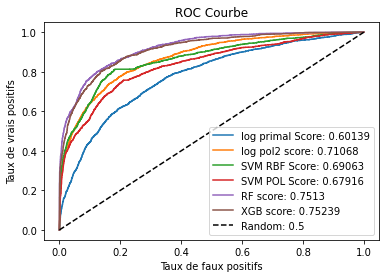

In [39]:
plt.plot(fpr_log_primal, tpr_log_primal, label = 'log primal Score: ' + str(round(auc_log_primal, 5)))
plt.plot(fpr_log_pol2, tpr_log_pol2, label = 'log pol2 score: ' + str(round(auc_log_pol2, 5)))
plt.plot(fpr_SVM_RBF, tpr_SVM_RBF, label = 'SVM RBF Score: ' + str(round(auc_SVM_RBF, 5)))
plt.plot(fpr_SVM_POL, tpr_SVM_POL, label = 'SVM POL Score: ' + str(round(auc_SVM_POL, 5)))
plt.plot(fpr_RF, tpr_RF, label = 'RF score: ' + str(round(auc_RF, 5)))
plt.plot(fpr_XGB, tpr_XGB, label = 'XGB score: ' + str(round(auc_XGB, 5)))
plt.plot([0,1], [0,1], 'k--', label = 'Random: 0.5')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('ROC Courbe')
plt.legend(loc='best')
#plt.savefig('roc_results_ratios.png')
plt.show()

À partir des résultats ci-dessus, mon objectif principal est de prédire les clients qui seront éventuellement désengagés afin qu'ils puissent être placés dans une sorte de schéma pour éviter le désengagement. Par conséquent, les mesures de rappel sur les 1 sont plus importantes pour moi que le score de précision global du maquette.

Étant donné que dans les données nous n'avions que 20% de désabonnement, un rappel supérieur à cette référence sera déjà une amélioration mais nous voulons atteindre le plus haut possible tout en essayant de maintenir une haute précision afin que la banque puisse former efficacement ses ressources vers clients mis en évidence par le modèle sans gaspiller trop de ressources sur les faux positifs.

D'après l'examen des modèles ajustés ci-dessus, le meilleur modèle qui offre un équilibre décent entre le rappel et la précision est la forêt aléatoire où, selon l'ajustement sur l'ensemble d'entraînement, avec un score de précision sur 1 de 0,88, sur tous les clients qui le modèle pense qu'il y aura un taux de désabonnement, 88% le font réellement et avec un score de rappel de 0,53 sur les 1, le modèle est capable de mettre en évidence 53% de tous ceux qui ont engagés.

### Tester la précision de la prédiction du modèle sur les données de test

In [40]:
# Effectuer la transformation des données pour les données de test
df_test = DfPrepPipeline(df_test,df_train.columns,minVec,maxVec)
df_test = df_test.mask(np.isinf(df_test))
df_test = df_test.dropna()
df_test.shape

(1996, 17)

In [41]:
print(classification_report(df_test.Exited,  RF.predict(df_test.loc[:, df_test.columns != 'Exited'])))

              precision    recall  f1-score   support

           0       0.87      0.98      0.92      1607
           1       0.83      0.40      0.54       389

    accuracy                           0.87      1996
   macro avg       0.85      0.69      0.73      1996
weighted avg       0.86      0.87      0.85      1996



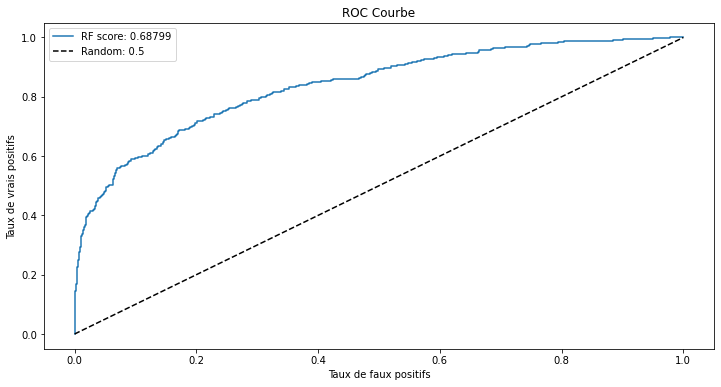

In [44]:
auc_RF_test, fpr_RF_test, tpr_RF_test = get_auc_scores(df_test.Exited, RF.predict(df_test.loc[:, df_test.columns != 'Exited']),
                                                       RF.predict_proba(df_test.loc[:, df_test.columns != 'Exited'])[:,1])
plt.figure(figsize = (12,6), linewidth= 1)
plt.plot(fpr_RF_test, tpr_RF_test, label = 'RF score: ' + str(round(auc_RF_test, 5)))
plt.plot([0,1], [0,1], 'k--', label = 'Random: 0.5')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('ROC Courbe')
plt.legend(loc='best')
#plt.savefig('roc_results_ratios.png')
plt.show()

## 7. Conclusion

La précision du modèle sur des données de test inédites est légèrement plus élevée en ce qui concerne la prédiction des 1, c'est-à-dire les clients qui sont désengager. Cependant, dans la mesure où le modèle a une grande précision, il manque encore environ la moitié de ceux qui finissent par désengagement. Cela pourrait être amélioré en permettant de recycler le modèle avec plus de données au fil du temps tout en travaillant avec le modèle pour économiser les 41 % qui auraient été désengagés.